# Baseline: ecapa

In [31]:
from speechbrain.nnet.losses import LogSoftmaxWrapper, AdditiveAngularMargin
from speechbrain.pretrained import EncoderClassifier
from data import create_dataloader
import torch
import numpy as np
from sklearn.metrics import classification_report, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import os
import matplotlib.pyplot as plt

## Configuration

In [32]:
model_name='spkrec-ecapa-voxceleb'
dir='speaker'
root=os.path.join('dataset',model_name,dir)

## Data preparation

In [33]:
def compute_features(model, loader, criterion):
    features=[]
    labels=[]
    lab2ind=model.hparams.label_encoder.lab2ind
    for i, data in enumerate(loader):

        x, label, y = data
        x = x.cuda()
        with torch.inference_mode():
            pred, score, _, _ = model.classify_batch(x)
        features.append([score])
        labels.append(label)
    return torch.tensor(features).numpy(), torch.tensor(labels).numpy()


In [34]:
if os.path.exists(root):
    train=np.load(os.path.join(root,'train.npy'))
    val=np.load(os.path.join(root,'val.npy'))
    test=np.load(os.path.join(root,'test.npy'))
else:
    os.makedirs(root)
    criterion=LogSoftmaxWrapper(AdditiveAngularMargin(margin=0.2, scale=30))
    model=EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", run_opts={"device": "cuda"})
    model.eval()
    train_loader, val_loader, test_loader = create_dataloader(
        root=os.path.join(root,dir),
        data_root='/home/baole/cmu/2023spring/11785/data/vox1/vox1_all/wav/',
        batch_size=1
    )

    train_x, train_y=compute_features(model, train_loader, criterion)
    val_x, val_y=compute_features(model, val_loader, criterion)
    test_x, test_y=compute_features(model, test_loader, criterion)

    train=np.column_stack((train_x,train_y))
    np.save(os.path.join(root,'train.npy'),train)
    val=np.column_stack((val_x,val_y))
    np.save(os.path.join(root,'val.npy'),val)
    test=np.column_stack((test_x,test_y))
    np.save(os.path.join(root,'test.npy'),test)

## Visualization

In [35]:
def visualize(dataset):
    plt.scatter(dataset[:,0],dataset[:,1])
    plt.xlabel('confidence')
    plt.ylabel('label (pos/neg)')
    plt.show()

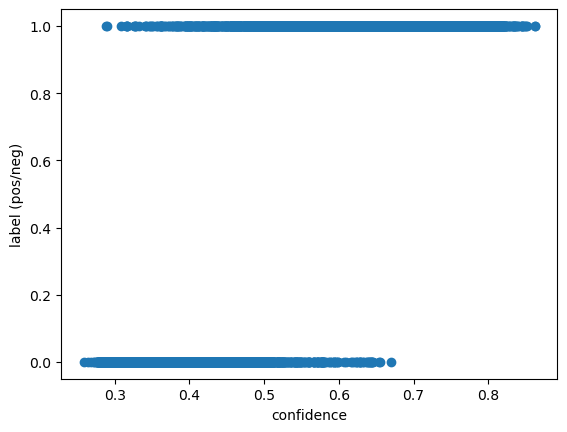

In [36]:
visualize(train)

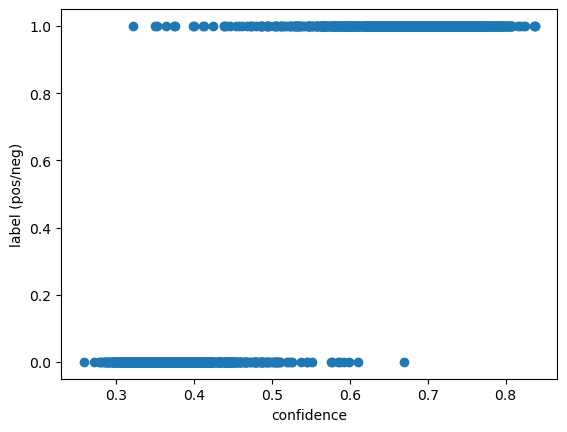

In [37]:
visualize(val)

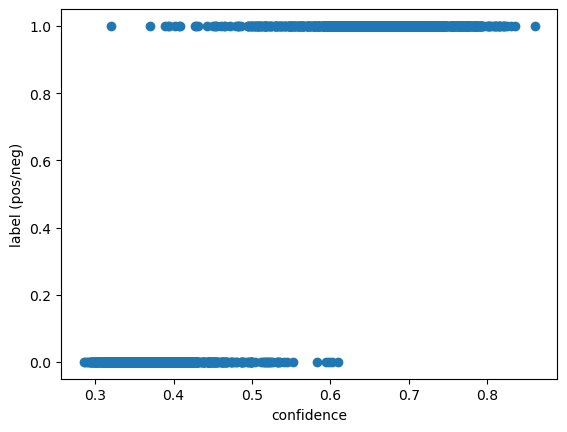

In [38]:
visualize(test)

## Evaluation

In [39]:
def classify(classifier, train, test):
    classifier.fit(train[:,:-1], train[:,-1])
    pred=classifier.predict(test[:,:-1])
    print(classification_report(test[:,-1],pred))
    RocCurveDisplay.from_estimator(classifier,test[:,:-1],test[:,-1])
    plt.show()

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1000
         1.0       0.97      0.97      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



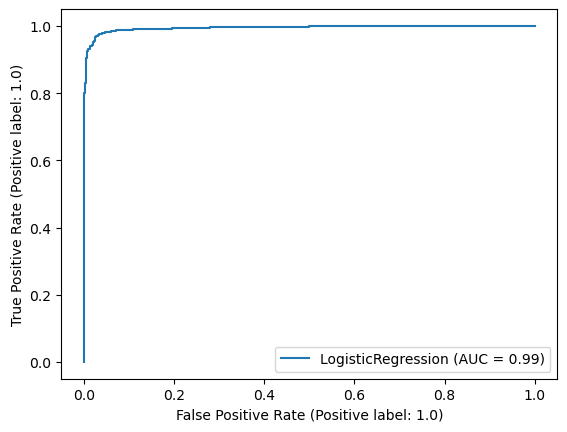

In [40]:
classify(LogisticRegression(),train,test)

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1000
         1.0       0.97      0.97      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



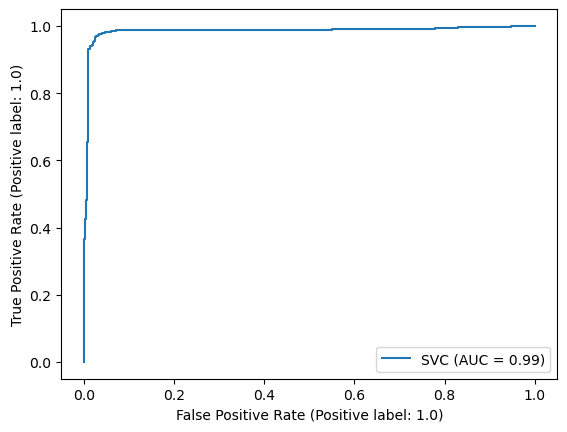

In [41]:
classify(SVC(),train,test)

              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95      1000
         1.0       0.95      0.96      0.96      1000

    accuracy                           0.95      2000
   macro avg       0.96      0.95      0.95      2000
weighted avg       0.96      0.95      0.95      2000



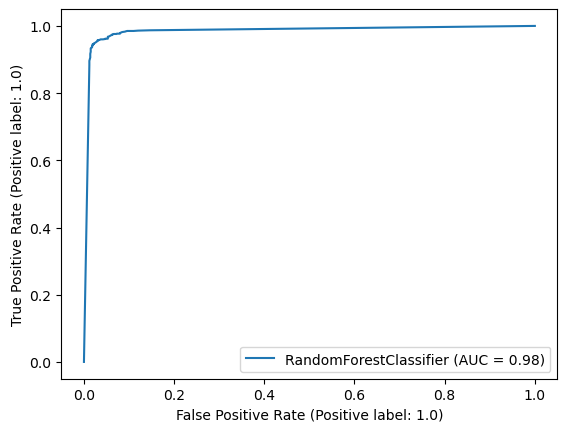

In [42]:
classify(RandomForestClassifier(),train,test)

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97      1000
         1.0       0.96      0.97      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



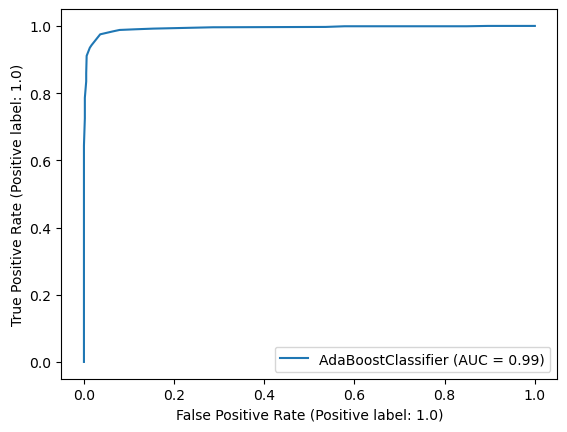

In [43]:
classify(AdaBoostClassifier(),train,test)

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97      1000
         1.0       0.96      0.97      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



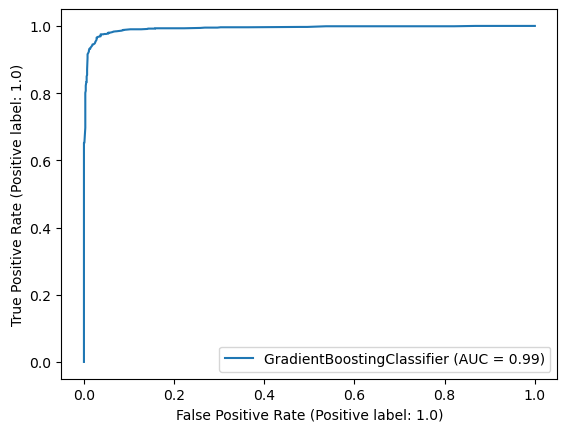

In [44]:
classify(GradientBoostingClassifier(),train,test)

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97      1000
         1.0       0.97      0.97      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



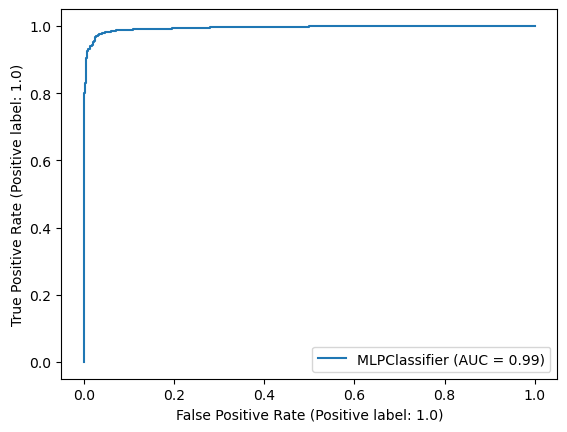

In [45]:
classify(MLPClassifier(),train,test)